In [1]:
%matplotlib notebook
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import random

In [2]:
(x_train,y_train),(x_test,y_test)=tf.keras.datasets.mnist.load_data()
print(x_train.shape)
print(x_test.shape)

11493376/11490434 [==============================] - 0s 0us/step
(60000, 28, 28)
(10000, 28, 28)


Reshaping and normalization

In [3]:
x_train=np.reshape(x_train,(60000,784))/255.
x_test=np.reshape(x_test,(10000,784))/255.
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


Function to plot triplets

In [14]:
def plot_triplet(triplet):
  plt.figure(figsize=(6,2))
  for i in range(0,3):
    plt.subplot(1,3,i+1)
    plt.imshow(np.reshape(triplet[i],(28,28)),cmap='binary')
    plt.xticks([])
    plt.yticks([])
  plt.show()

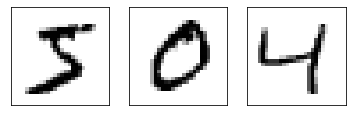

In [15]:
plot_triplet([x_train[0],x_train[1],x_train[2]])

Creating triplets

In [21]:
def create_batch(batch_size):
  anchors=np.zeros((batch_size,784))
  positives=np.zeros((batch_size,784))
  negatives=np.zeros((batch_size,784))
  for i in range(0,batch_size):
    index=random.randint(0,60000-1)
    anchors[i]=x_train[index]
    y=y_train[index]
    positive_indices=np.squeeze(np.where(y_train==y))
    negative_indices=np.squeeze(np.where(y_train!=y))
    positives[i]=x_train[positive_indices[random.randint(0,len(positive_indices)-1)]]
    negatives[i]=x_train[negative_indices[random.randint(0,len(negative_indices)-1)]]
  return [anchors,positives,negatives]

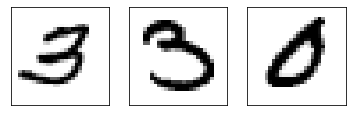

In [25]:
plot_triplet(create_batch(1))

A simple neural network for embedding

In [27]:
emb_dim=64
embedding_model=tf.keras.models.Sequential([
                                            tf.keras.layers.Dense(64,activation='relu',input_shape=(784,)),
                                            tf.keras.layers.Dense(emb_dim,activation='sigmoid')
])
embedding_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                50240     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
Total params: 54,400
Trainable params: 54,400
Non-trainable params: 0
_________________________________________________________________


In [28]:
example_emb=embedding_model.predict(np.expand_dims(x_train[0],axis=0))[0]
print(example_emb)

[0.60305667 0.4596309  0.4917099  0.62034076 0.4365832  0.37091592
 0.4893782  0.48445165 0.5888337  0.47345856 0.62621963 0.42387944
 0.3942499  0.57659847 0.4828853  0.5788227  0.40397495 0.36668876
 0.5110942  0.52154547 0.44403887 0.4896294  0.4790429  0.51135963
 0.44863674 0.5605141  0.56980586 0.5471463  0.3872272  0.49509498
 0.45117217 0.5431652  0.36918798 0.39491314 0.48758522 0.4196718
 0.40287095 0.642678   0.3862845  0.4965592  0.5735239  0.41218486
 0.45793805 0.44866097 0.44115257 0.54718804 0.5909255  0.41723055
 0.4423132  0.5265818  0.52910346 0.4781664  0.55941695 0.38083544
 0.50534207 0.6494209  0.5406699  0.5275402  0.4106305  0.57585806
 0.46936765 0.59937704 0.45755988 0.52398807]


Building the Siamese network

In [33]:
input_anc=tf.keras.layers.Input(shape=(784,))
input_pos=tf.keras.layers.Input(shape=(784,))
input_neg=tf.keras.layers.Input(shape=(784,))
embedding_anc=embedding_model(input_anc)
embedding_pos=embedding_model(input_pos)
embedding_neg=embedding_model(input_neg)
output=tf.keras.layers.concatenate([embedding_anc,embedding_pos,embedding_neg],axis=1)
network=tf.keras.models.Model(
    [input_anc,input_pos,input_neg],
    output
)
network.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 784)]        0                                            
__________________________________________________________________________________________________
input_14 (InputLayer)           [(None, 784)]        0                                            
__________________________________________________________________________________________________
input_15 (InputLayer)           [(None, 784)]        0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 64)           54400       input_13[0][0]                   
                                                                 input_14[0][0]        

Defining the triplet loss and data genertaor

In [34]:
def triplet_loss(alpha,emb_dim):
  def loss(y_true,y_pred):
    anc,pos,neg=y_pred[:,:emb_dim],y_pred[:,emb_dim:2*emb_dim],y_pred[:,2*emb_dim:]
    dp=tf.reduce_mean(tf.square(anc-pos),axis=1)
    dn=tf.reduce_mean(tf.square(anc-neg),axis=1)
    return tf.maximum(dp-dn+alpha,0.)
  return loss

In [35]:
def data_generator(batch_size,emb_dim):
  while True:
    x=create_batch(batch_size)
    y=np.zeros((batch_size,3*emb_dim))
    yield x,y

Compile and train

In [36]:
batch_size=1024
epochs=10
steps_per_epoch=int(60000/batch_size)
network.compile(loss=triplet_loss(alpha=0.2,emb_dim=emb_dim),optimizer='adam')

In [38]:
history=network.fit(
    data_generator(batch_size,emb_dim),
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    verbose=True
)

Epoch 1/10
58/58 [==============================] - 25s 430ms/step - loss: 0.1210
Epoch 2/10
58/58 [==============================] - 25s 434ms/step - loss: 0.0539
Epoch 3/10
58/58 [==============================] - 25s 433ms/step - loss: 0.0421
Epoch 4/10
58/58 [==============================] - 25s 432ms/step - loss: 0.0357
Epoch 5/10
58/58 [==============================] - 25s 431ms/step - loss: 0.0315
Epoch 6/10
58/58 [==============================] - 25s 431ms/step - loss: 0.0288
Epoch 7/10
58/58 [==============================] - 25s 432ms/step - loss: 0.0263
Epoch 8/10
58/58 [==============================] - 25s 428ms/step - loss: 0.0249
Epoch 9/10
58/58 [==============================] - 25s 434ms/step - loss: 0.0229
Epoch 10/10
58/58 [==============================] - 25s 438ms/step - loss: 0.0216


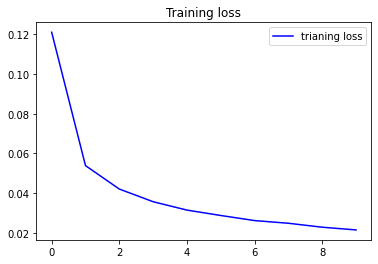

In [40]:
loss=history.history['loss']
epochs=range(len(loss))
plt.plot(epochs,loss,'b',label='trianing loss')
plt.title('Training loss')
plt.legend()
plt.show()